# Introduction
- The goal of this section is to train a convolutional neural network on custom images (radiographss) from scratch. To achieve this, there are few operations we need to perform, which includes:
  - Connecting google colab to our google drive
  - Data Preparation: creating training and test data from the raw data
  - Building the CNN architecture
  - Training the network with and without transfer learning using pretrained models such as Vgg16, ResNet50, DenseNet121, MobileNetV1 and EfficientNet


- Dataset:https://stanfordmlgroup.github.io/competitions/mura/

In [ ]:
# Connect Google Colab to Google Drive
# from google.colab import drive
# drive.mount("/content/drive")

In [1]:
# install opencv-python
!pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# install keras-tuner

!pip install keras-tuner


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# smalldataset 128 binary train-test split

In [3]:
# import the required libraries
import cv2
import numpy as np
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow import keras
import keras_tuner as kt

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [4]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(1042)
import random
random.seed(1042)
tf.random.set_seed(1042)

# smalldata 128 binary vgg16

Found 686 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Epoch 1/10
22/22 [==============================] - 1105s 51s/step - loss: 1.2341 - accuracy: 0.5219 - val_loss: 0.6659 - val_accuracy: 0.6020
Epoch 2/10
22/22 [==============================] - 1103s 51s/step - loss: 0.7395 - accuracy: 0.5641 - val_loss: 0.7119 - val_accuracy: 0.5408
Epoch 3/10
22/22 [==============================] - 1102s 51s/step - loss: 0.6100 - accuracy: 0.6706 - val_loss: 0.6734 - val_accuracy: 0.5850
Epoch 4/10
22/22 [==============================] - 1193s 55s/step - loss: 0.5854 - accuracy: 0.6720 - val_loss: 0.6574 - val_accuracy: 0.5850
Epoch 5/10
22/22 [==============================] - 1372s 63s/step - loss: 0.6392 - accuracy: 0.6224 - val_loss: 0.6924 - val_accuracy: 0.5442
Epoch 6/10
22/22 [==============================] - 1149s 52s/step - loss: 0.5610 - accuracy: 0.6939 - val_loss: 0.6743 - val_accuracy: 0.5918
Epoch 7/10
22/22 [=

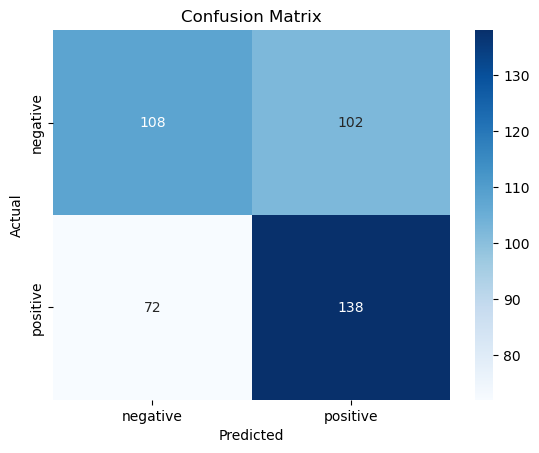

Sensitivity: 0.6571428571428571
Specificity: 0.5142857142857142


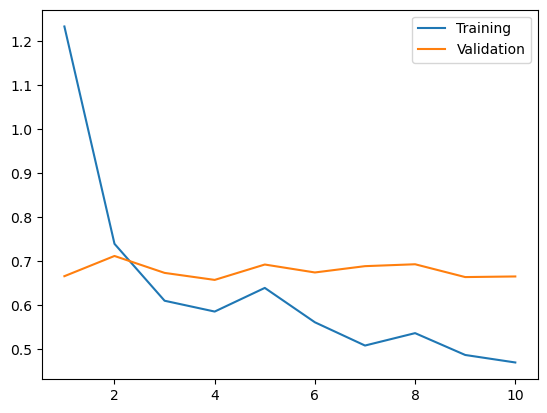

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Define paths
train_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/128/Binary/train"
test_dir = "C:/Users/OLASUNKANMI/Desktop/UoL DS Course files/Semester C/UoL Research Project Materials/New_Mura/small_dataset/128/Binary/test"


# Data Preprocessing
image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

# Load VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=out)

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Test Data
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Visualize the loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.legend(loc="best")
plt.show()